In this project on stock market prediction, I plan to train the dataset on the following models.

- Auto ARIMAX<br>
- Facebook Prophet<br>
- LightGBM<br>
- LSTM<br>

- Below, `%reload_ext autoreload` is a magic command in jupyter notebook that enables autoreloading of imported modules in IPython. It allows changes made to a module's code to be immediately reflected in the notebook, without having to manually restart the kernel or reload the module.
- `%autoreload 2` reloads all modules before executing a new line of code.
- `%matplotlib inline` helps to make visualization within the notebook

In [1]:
# INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Getting the required packages 

We first have to install the following packages using pip.
- package `pmdarima` for importing `auto_arima` module to train dataset with Auto ARIMAX model
- prophet for training Facebook Prophet
- lightgbm

In [2]:
#installing packages

#uncomment below if packages are not already installed in your local environment
#!pip install pmdarima
#!pip install lightgbm
#!pip install prophet --no-cache-dir

A `!` mark is needed before `pip` for shell command. If you are installing it in your local machine from command line interface (CLI), then you don't need this exclamation (`!`) mark.  

In [3]:
# importing PACKAGES:

# data analysis
import numpy as np
import pandas as pd

#ML model training
from pmdarima import auto_arima
from prophet import Prophet
import lightgbm as lgb

#evaluation metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


# 2. Getting the dataset

- For link to the dataset: [Click here](https://www.kaggle.com/datasets/aayushmishra1512/faang-complete-stock-data?select=Netflix.csv).<br>

- Above dataset contains stocks of Apple for about 40 years from 1980 to 2020 

In [9]:
# make sure dataset with -csv extension is there in the directory
!ls

Apple.csv  ICICIBANK.csv  LICENSE  README.md  stock-market-prediction.ipynb


In [10]:
#1. use read_csv function from pandas libraray to read the dataset 
#2. store contents of the file in a DataFrame object df
df = pd.read_csv("Apple.csv")

In [11]:
#print first 5 rows of the dtatset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600.0


In the above dataset, 
- `Date` is in yyyy-mm-dd format
- **Volume**  is the **target variable** to predict. 

## 3. Getting to know the dataset

In [14]:
df.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume       float64
dtype: object

We see that, all features are numerics except, date. This makes sense. All features have their right datatype.

In [16]:
# Getting the basic information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       10016 non-null  object 
 1   open       10015 non-null  float64
 2   high       10015 non-null  float64
 3   low        10015 non-null  float64
 4   close      10015 non-null  float64
 5   adj_close  10015 non-null  float64
 6   volume     10015 non-null  float64
dtypes: float64(6), object(1)
memory usage: 547.9+ KB


In [18]:
df.shape

(10016, 7)

In [19]:
df.describe().round(2)

,open,high,low,close,adj_close,volume
count,10015.00,10015.00,10015.00,10015.00,10015.00,1.001500e+04
mean,9.01,9.11,8.92,9.02,8.48,3.413188e+08
std,16.84,17.03,16.68,16.87,16.47,3.426534e+08
min,0.05,0.05,0.05,0.05,0.04,1.388800e+06
25%,0.27,0.28,0.26,0.27,0.23,1.315944e+08
50%,0.44,0.45,0.43,0.44,0.37,2.285380e+08
75%,10.06,10.18,9.89,10.10,8.73,4.250092e+08
max,132.76,134.80,130.53,134.18,134.18,7.421641e+09


In [20]:
df['Date'].min()

'1980-12-12'

In [22]:
df['Date'].max()

'2020-09-01'

Thus we have have datas for about 40 years in 10k rows.

## 4. formatting the dataset 

#### Making all feature names consistent i.e. all are small letters and spaces are replaced by a underscore `_` 

In [23]:
df.columns  = df.columns.str.lower().str.replace(' ','_')

In [24]:
df.head()

,date,open,high,low,close,adj_close,volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600.0


We have to change the datatype of `date` feature from `object` to `datetime` before we proceed with any time series analysis. Look into Pandas [time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) for these tools.

In [25]:
# Converting the Date column from Object data type to Datetime64 format:
df.date = pd.to_datetime(df.date)

In [26]:
# Getting the basic information after dtype change:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       10016 non-null  datetime64[ns]
 1   open       10015 non-null  float64       
 2   high       10015 non-null  float64       
 3   low        10015 non-null  float64       
 4   close      10015 non-null  float64       
 5   adj_close  10015 non-null  float64       
 6   volume     10015 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 547.9 KB


We see that dtype of `date` is now changed to `datetime64[ns]`.

In [27]:
df.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume              float64
dtype: object

In [28]:
# Getting the sum count of missing values in each column:
df.isnull().sum()

date         0
open         1
high         1
low          1
close        1
adj_close    1
volume       1
dtype: int64

We have very small amount of missing data. We can just neglect them.

# 3. Splitting the dataset 

**REMEMBER** We don't shuffle data in time-series, because if we shuffle, then the model may know the future data by mistake.

Splitting the data into train, validation and test (60/20/20) along with features.<br>

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle = False)

In [32]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle = False)

In [33]:
df_train.tail()

,date,open,high,low,close,adj_close,volume
6004,2004-09-27,0.659821,0.678214,0.657679,0.670179,0.579128,397516000.0
6005,2004-09-28,0.668929,0.683750,0.668750,0.679286,0.586997,353186400.0
6006,2004-09-29,0.677321,0.693929,0.675357,0.690714,0.596873,273509600.0
6007,2004-09-30,0.696429,0.701250,0.686607,0.691964,0.597953,425012000.0
6008,2004-10-01,0.698571,0.699821,0.688929,0.690536,0.596719,465404800.0


In [34]:
df_val.head()

,date,open,high,low,close,adj_close,volume
6009,2004-10-04,0.699643,0.699643,0.691964,0.692679,0.598571,574084000.0
6010,2004-10-05,0.688571,0.708393,0.685714,0.703036,0.607521,406162400.0
6011,2004-10-06,0.705357,0.727857,0.704821,0.725714,0.627118,446303200.0
6012,2004-10-07,0.723929,0.730893,0.704643,0.707500,0.611378,426148800.0
6013,2004-10-08,0.706429,0.710179,0.693571,0.697500,0.602737,359228800.0


In [35]:
df_val.tail()

,date,open,high,low,close,adj_close,volume
8007,2012-09-07,24.216072,24.374287,24.134644,24.301428,21.089975,329666400.0
8008,2012-09-10,24.301786,24.403214,23.646429,23.669285,20.541376,487998000.0
8009,2012-09-11,23.753929,23.932142,23.446428,23.592501,20.474737,503983200.0
8010,2012-09-12,23.816071,23.924999,23.428572,23.921072,20.759890,712233200.0
8011,2012-09-13,24.191786,24.482143,24.098928,24.392143,21.168703,598360000.0


In [36]:
df_test.head()

,date,open,high,low,close,adj_close,volume
8012,2012-09-14,24.641428,24.892143,24.567499,24.688572,21.425959,600474000.0
8013,2012-09-17,24.976786,24.992857,24.807501,24.992144,21.689409,398031200.0
8014,2012-09-18,24.995714,25.083214,24.872143,25.068214,21.755436,373503200.0
8015,2012-09-19,25.009285,25.142500,24.984642,25.075001,21.761318,326874800.0
8016,2012-09-20,24.969999,25.002142,24.772142,24.953571,21.655943,336568400.0


We see above that splitting is done successfully without splitting.

In [37]:
len(df_train), len(df_val), len(df_test), len(df_full_train),  len(df_train)+len(df_val), len(df_train)+len(df_val)+\
len(df_test), len(df)

(6009, 2003, 2004, 8012, 8012, 10016, 10016)

Above we see that lengths of the dataframes are consistent.

## 4. EDA on training dataset

## Missing value

In [38]:
df_train.head()

,date,open,high,low,close,adj_close,volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600.0


In [39]:
df_train.isnull().sum()

date         0
open         1
high         1
low          1
close        1
adj_close    1
volume       1
dtype: int64

We have negligible number od missing values. We'll neglect them for now.

Let's plot the target variable `volume` over time

<AxesSubplot: >

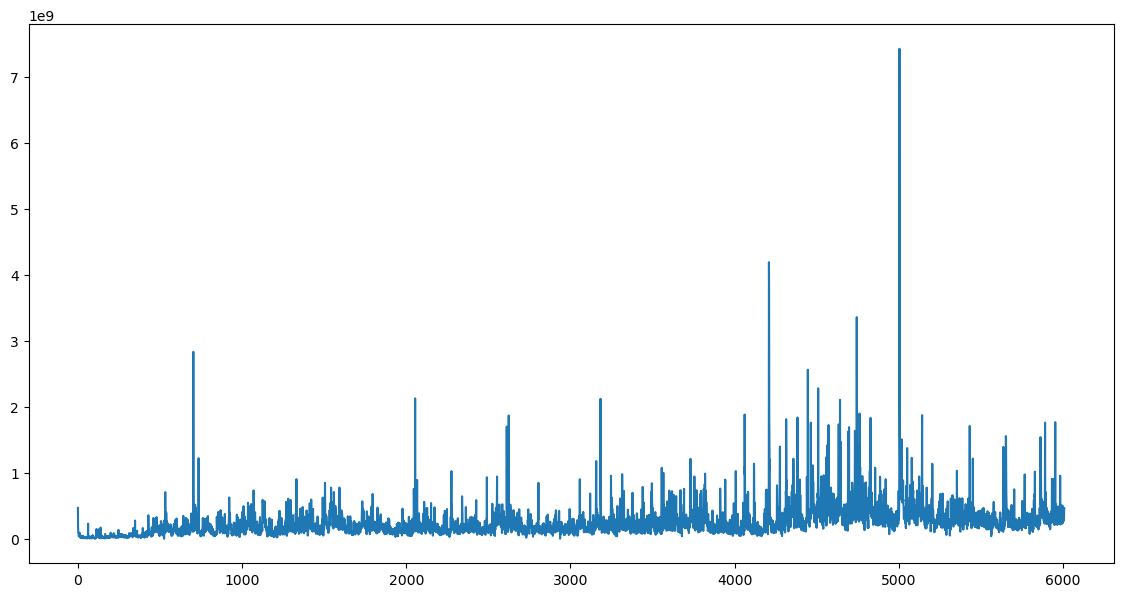

In [43]:
df_train.volume.plot(figsize=(14, 7))

In the above plot X-axis is along indices. It would be better to visualize with date. For this let's change indices into date and then plot again. 

In [45]:
#set the DataFrame's index to the "Date" column
#keep the Date column in the DataFrame
#inplace=True modifies the DataFrame in place instead of returning a new one.
df_train.set_index("date", drop=False, inplace=True)
df_train.head()

,date,open,high,low,close,adj_close,volume
date,,,,,,,
1980-12-12,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.101261,469033600.0
1980-12-15,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095978,175884800.0
1980-12-16,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088934,105728000.0
1980-12-17,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.091135,86441600.0
1980-12-18,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093777,73449600.0


<AxesSubplot: xlabel='date'>

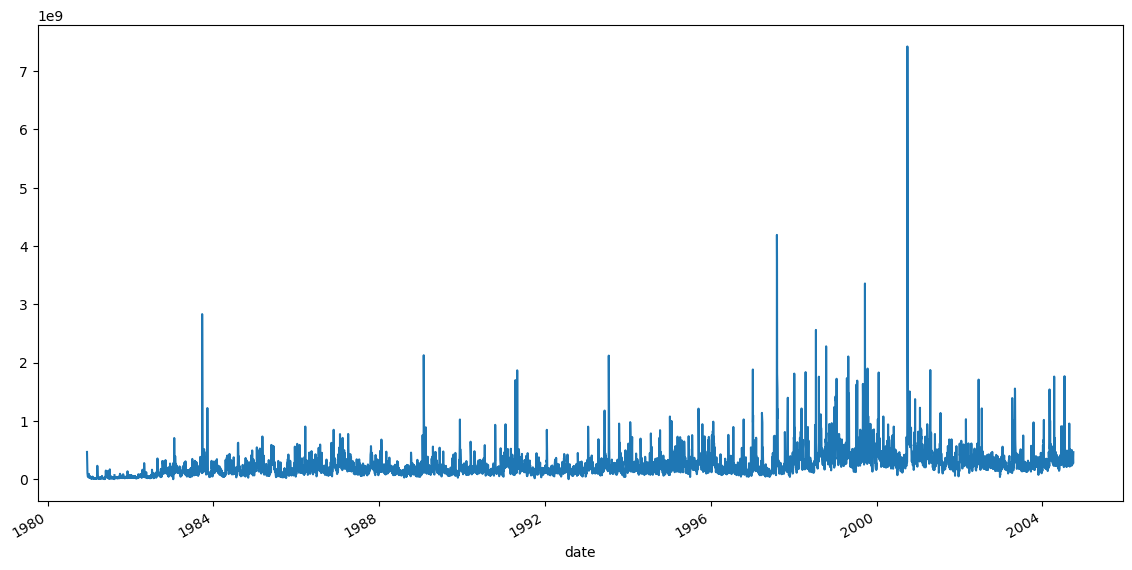

In [46]:
df_train.volume.plot(figsize=(14, 7))

**References**:

1. [A modern Time Series tutorial](https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial)
2. [Time Series Modelling & Stock Forecasting in Python](https://github.com/sukritishuk/ML_ZoomCamp_Article)